# Summary of Modeling for SPDR ETFs

In this notebook, I will summarize my findings from iterating through a host of models for the 11 sector ETFs for time frames of 1, 3, 6, and 12 months. The best scoring models performed incredibly well, and did not exhibit any characteristics of overfitting. That being said, on certain instances where the model predicted a given ETF would appreciate over its target time period and that ETF lost money, the losses had the potential to be quite large. I will begin by summarizing each sector's performance separately. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

import datetime as dt

# New import of my custom class
from classification_classes import Model
from spider_classes import Materials, Energy, Financials, Industrials, Technology, Staples, Utilities, Health, \
Consumer, Real_Estate, Communication_Services
from other_functions import compare_curves

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 35)
sns.set_style("dark")

import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

import pickle

In [ ]:
# Feature Importances for the best models of each sector/timeframe
feature_importances = pd.read_csv()

# Complete table of results
models_df = pd.read_csv()

# Original Data 
df = pd.read_csv()

In [2]:
# Load Pickled Classes -> if you want access, please reach out to me directly

with open('/Users/samalainabayeva/Desktop/Capstone Project/SPDR_classes.pkl', 'rb') as file:
    model_collection = pickle.load(file)

In [3]:
# Providing access to Class Objects

Materials = model_collection[0]
Energy = model_collection[1]
Financials = model_collection[2]
Industrials = model_collection[3]
Technology = model_collection[4]
Staples = model_collection[5]
Utilities = model_collection[6]
Health = model_collection[7]
Consumer_Disc = model_collection[8]
Real_Estate = model_collection[9]
Comms = model_collection[10]

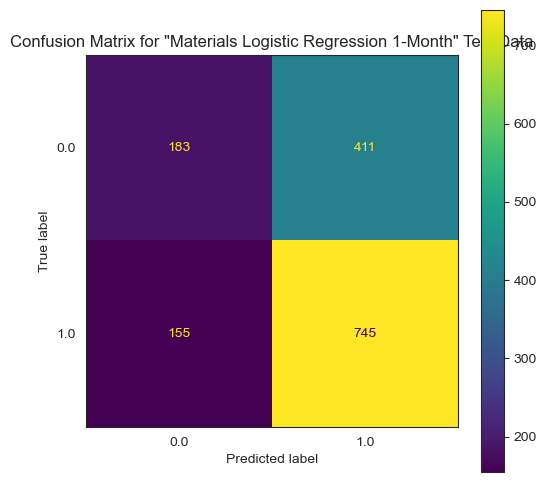

In [21]:
# Metrics of the models from the previous notebook

Materials_df = pd.read_csv()
Energy_df = 
Financials_df = 
Industrials_df = 
Technology_df = 
Staples_df = 
Utilities_df = 
Health_df = 
Consumer_Disc_df = 
Real_Estate_df = 
Comms_df = 

In [27]:
def describe_predictions(model, ticker, df, cat=1):
    targets = df[df["Ticker"] == ticker][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                                         'Twelve_Month_Change']]

    combined_df = model.X_test.join(targets)
    predictions = list(model.y_pred)
    combined_df["Y_PREDS"] = predictions

    return combined_df[combined_df["Y_PREDS"] == cat][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change',\
                                                     'Twelve_Month_Change']].describe()

# Materials